# CNN
- CNN(Convolutional Neural Network, CNN)
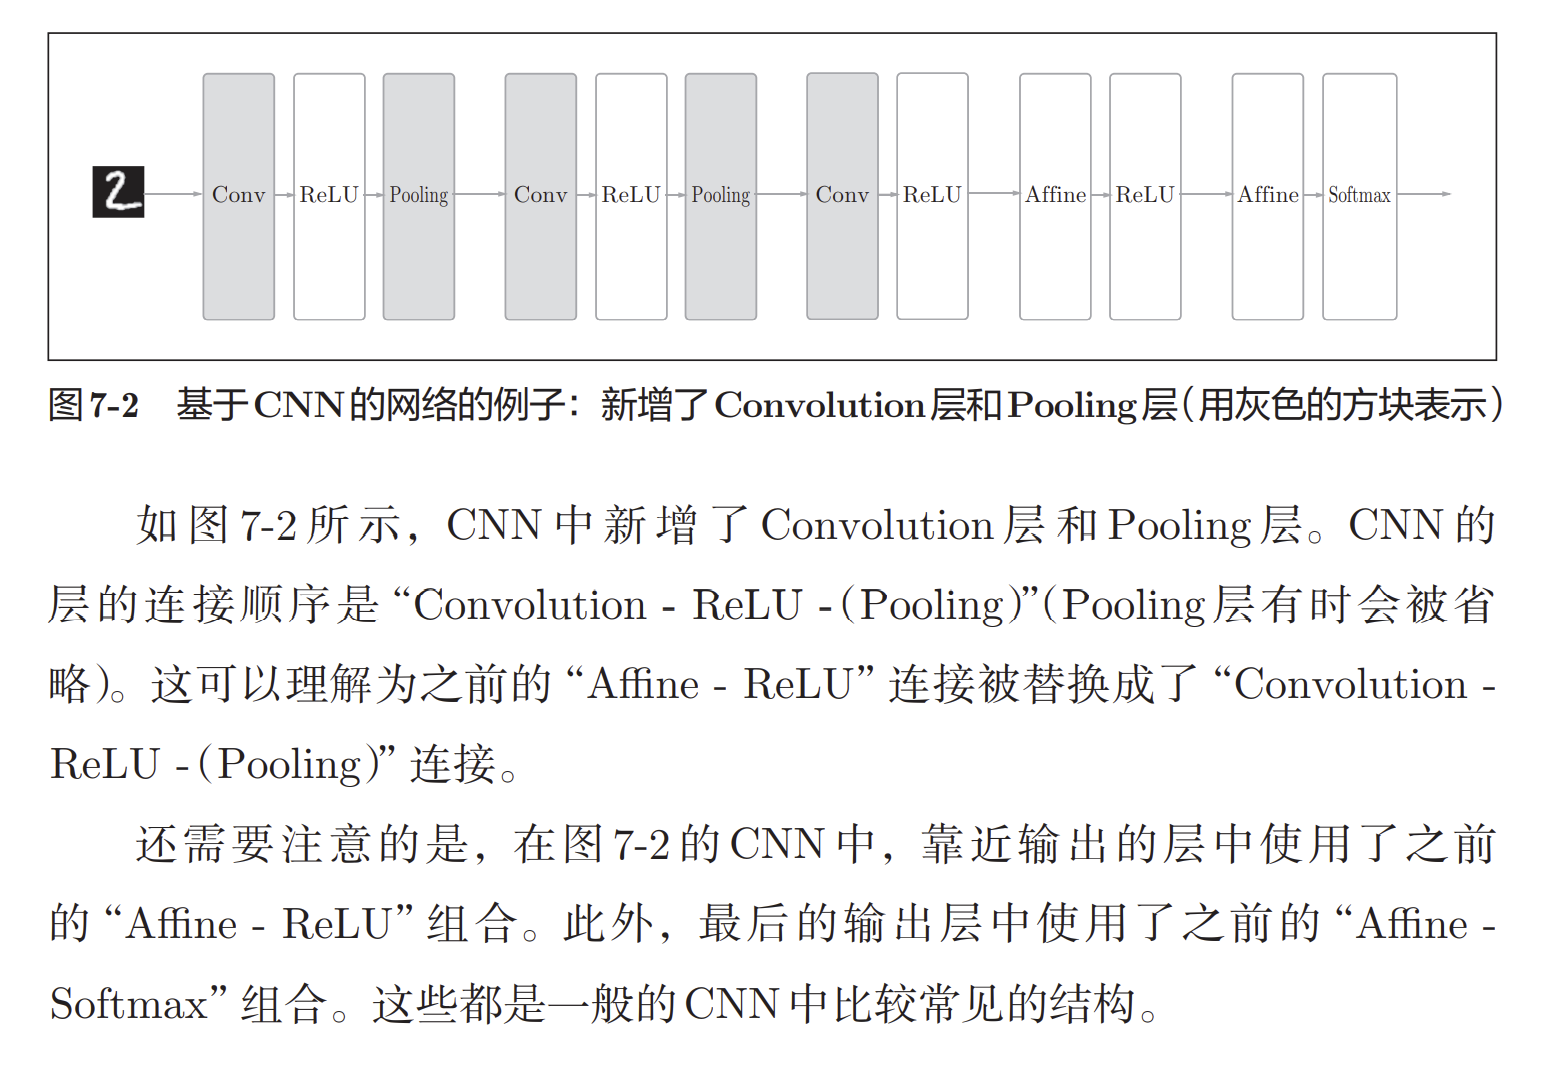

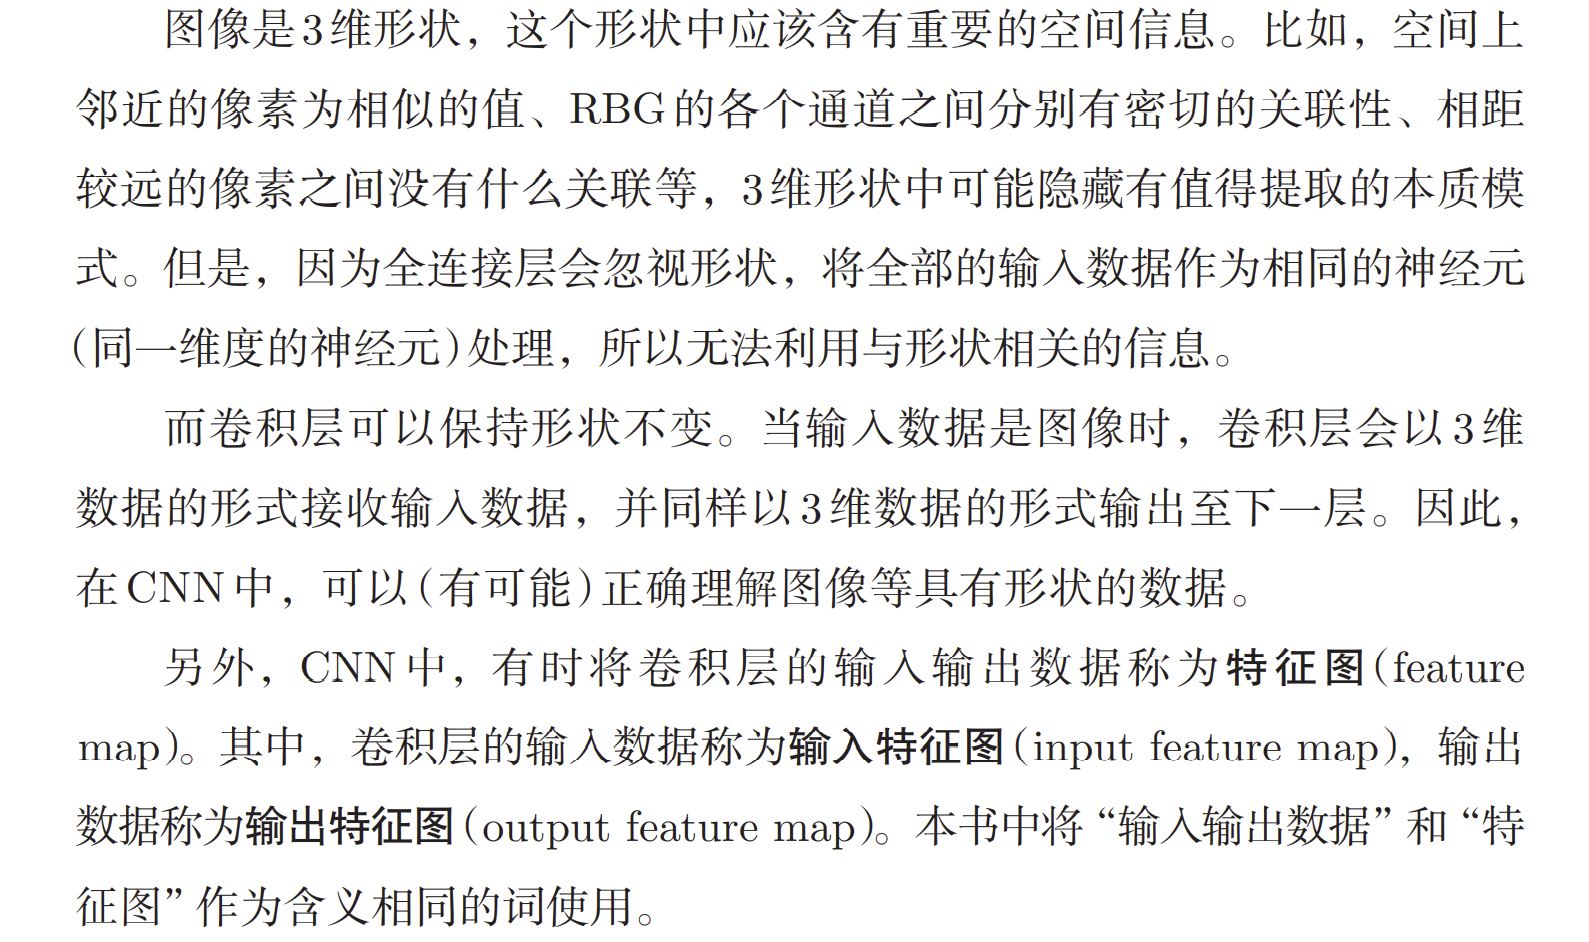

## 卷积运算
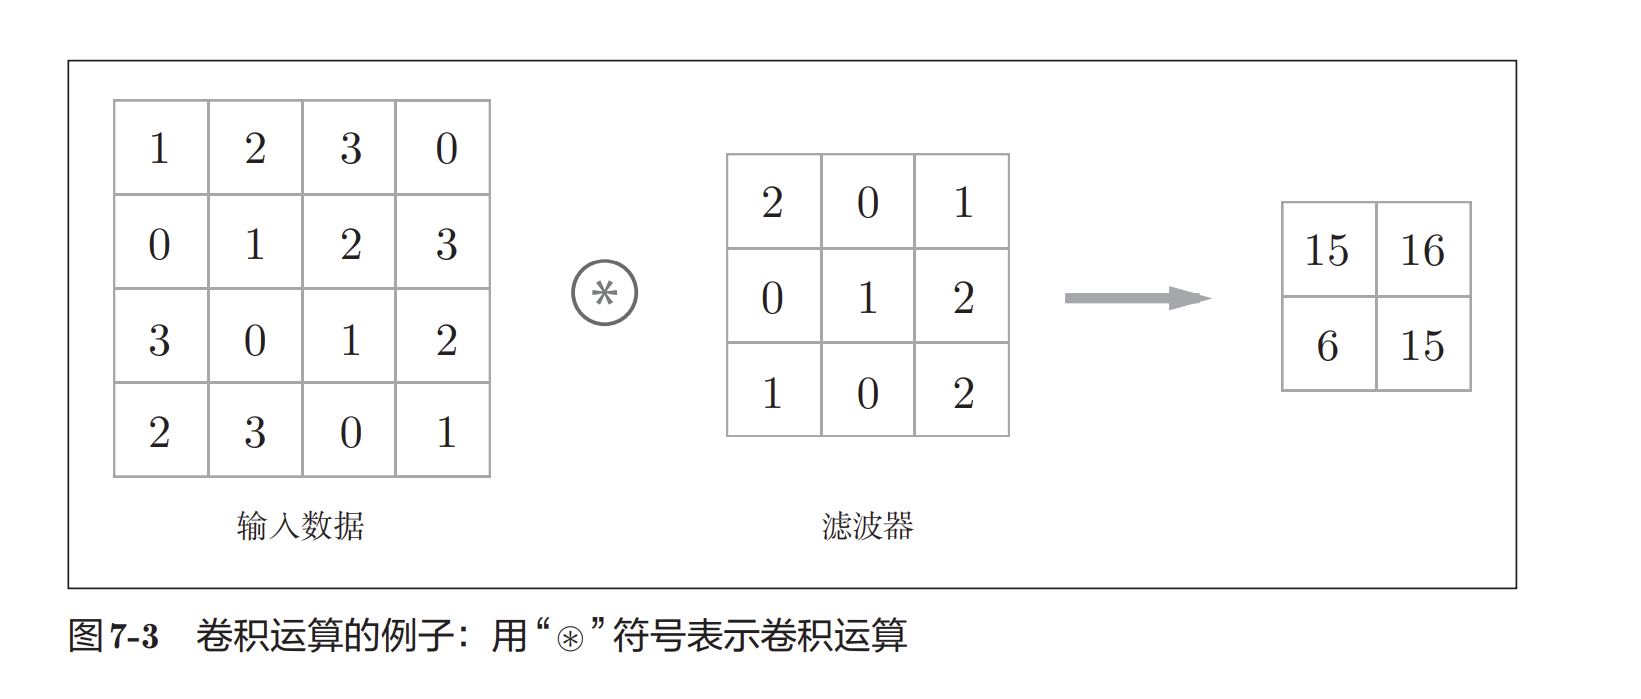

- 将各个位置上滤波器的元素和输入的对应元素相乘，然后再求和（有时将这个计算称为乘积累加运算）。

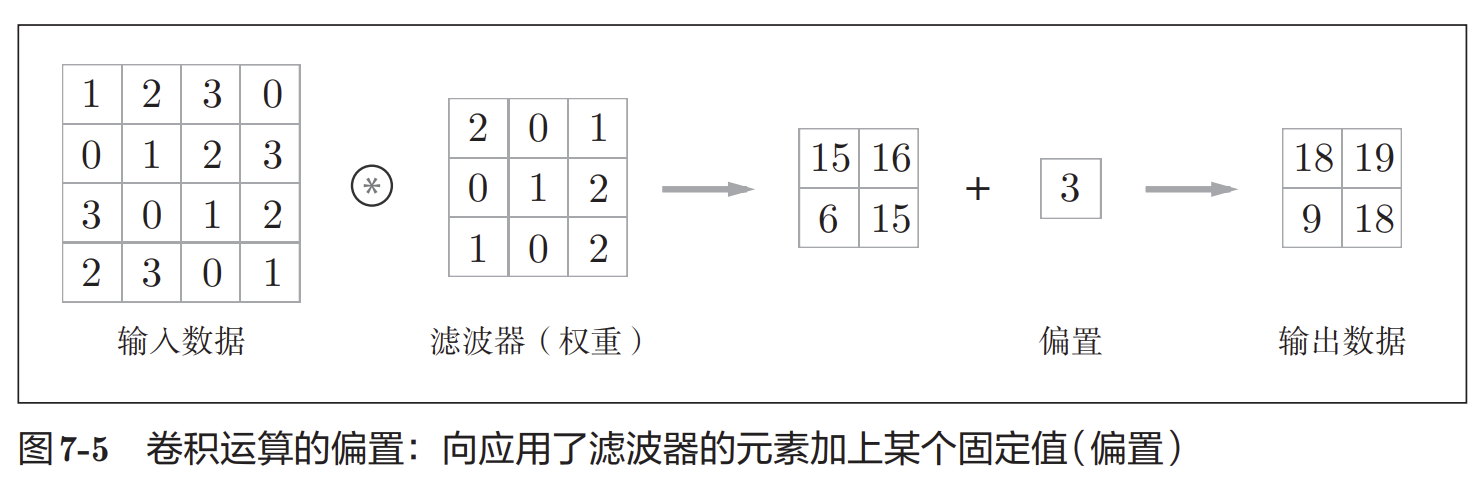

## 填充（padding）

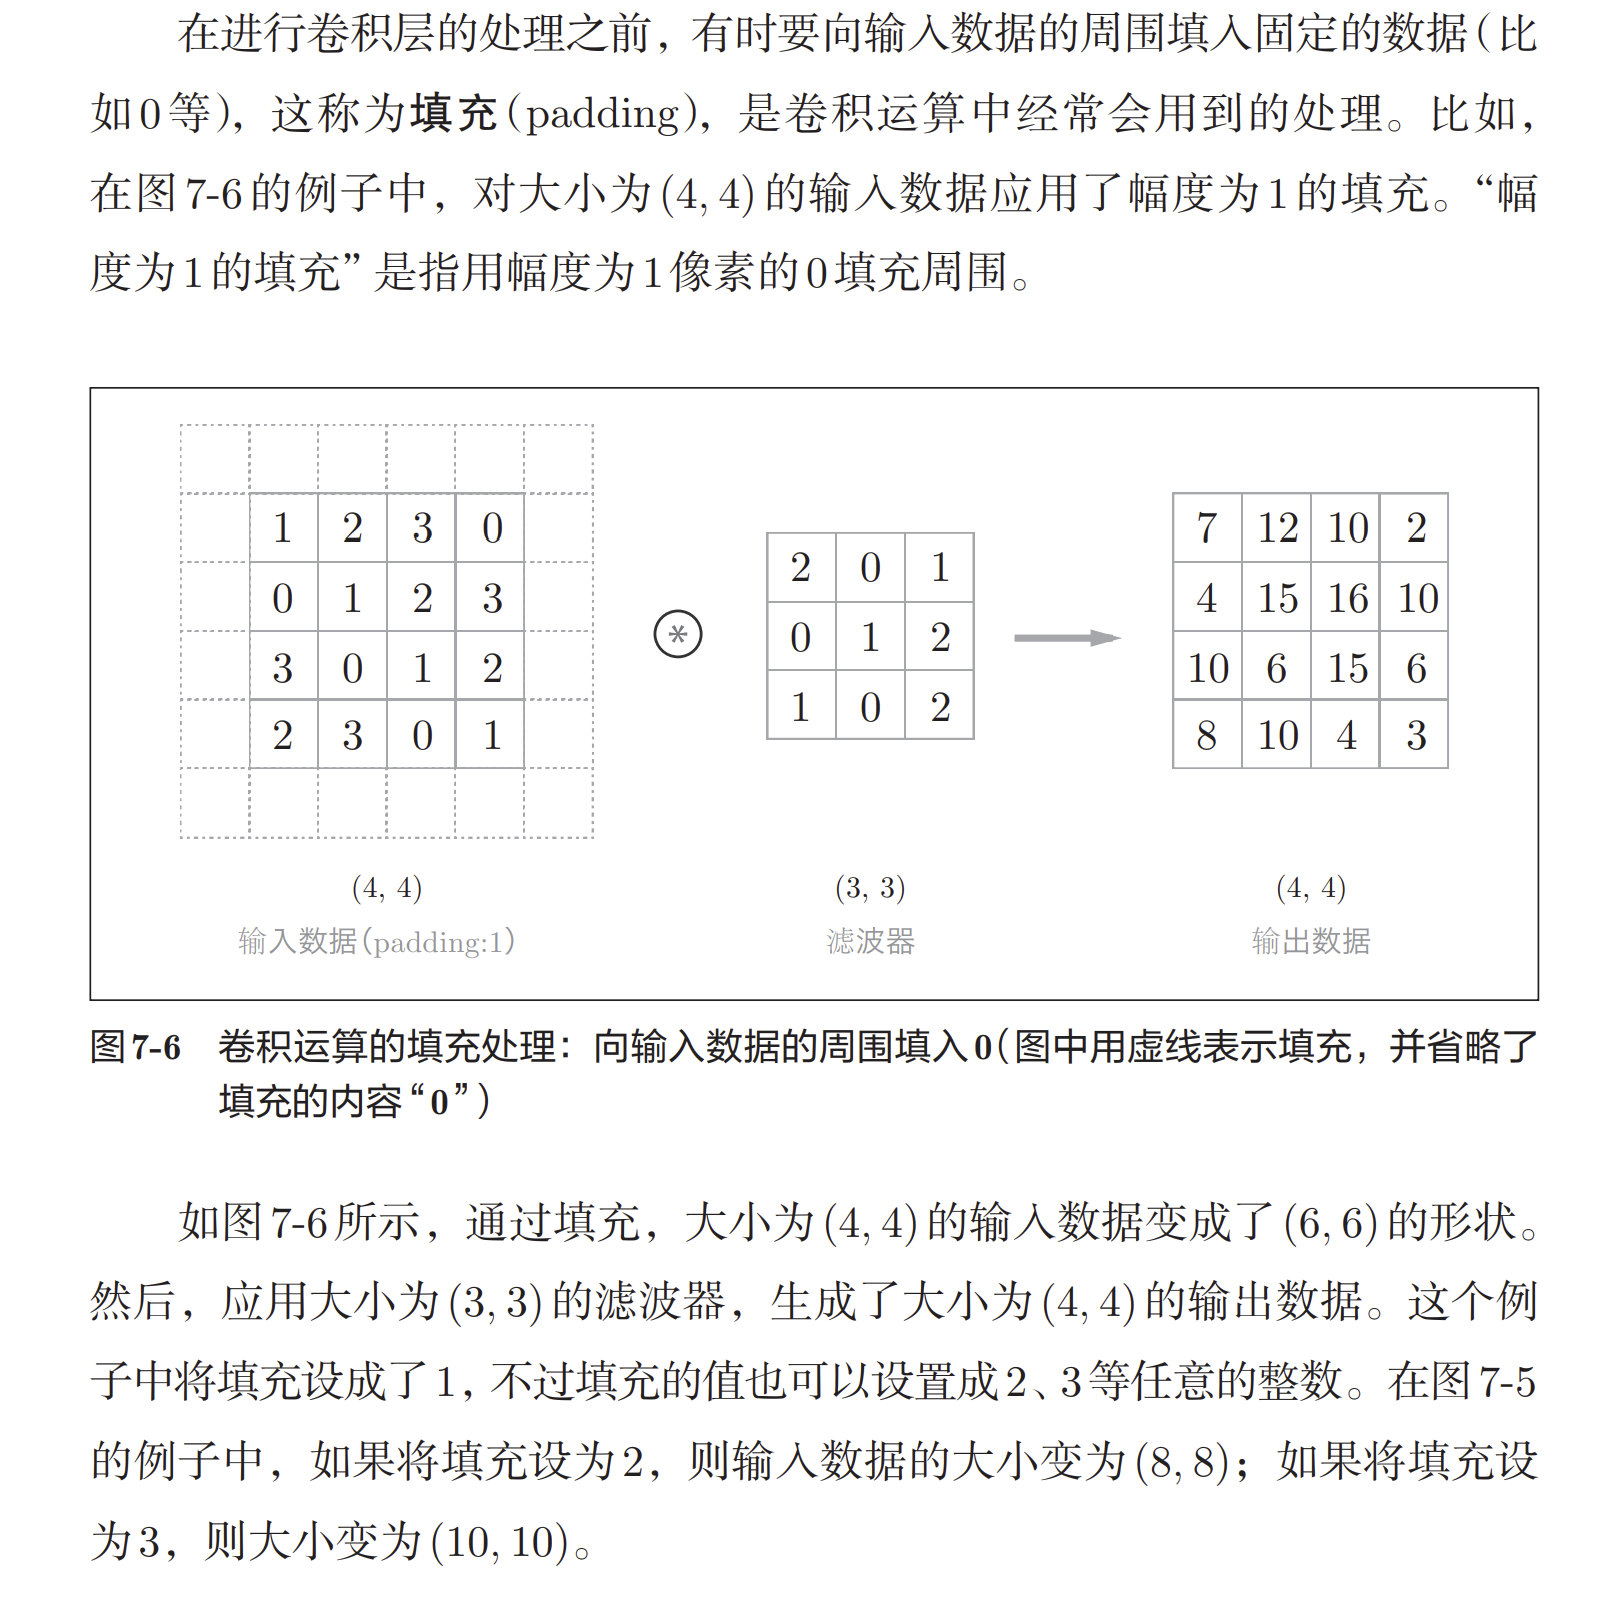

### 填充的目的
- 调整输出的大小
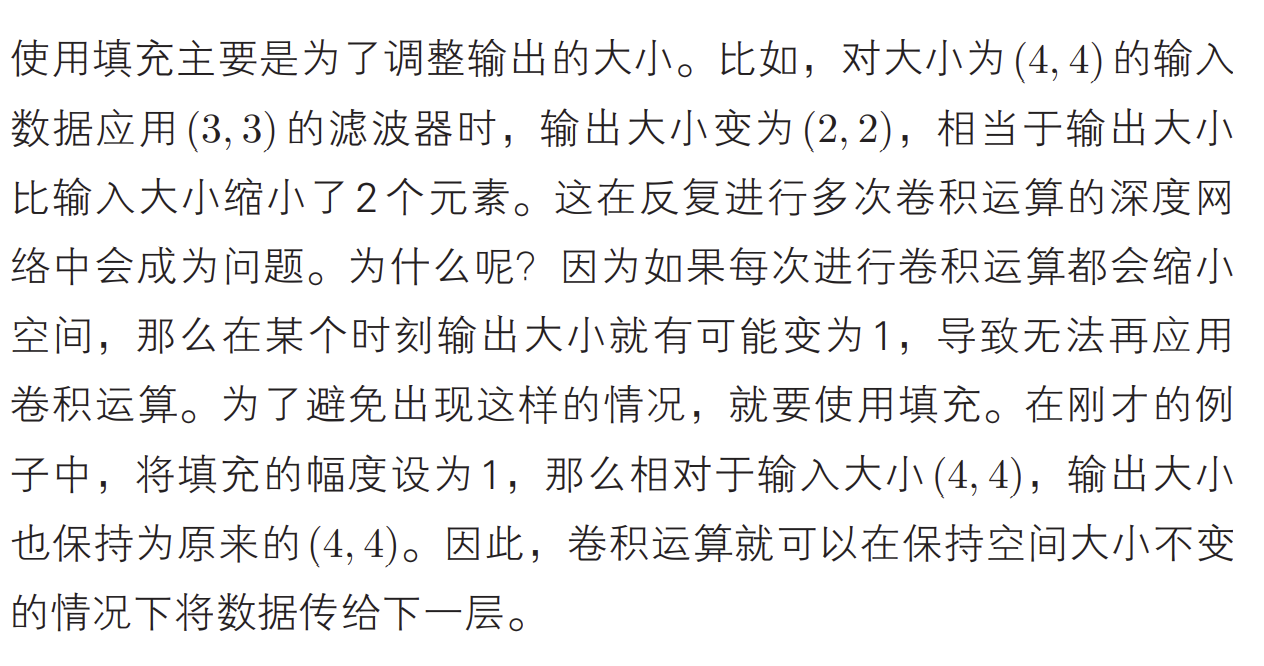

## 步幅(stride)
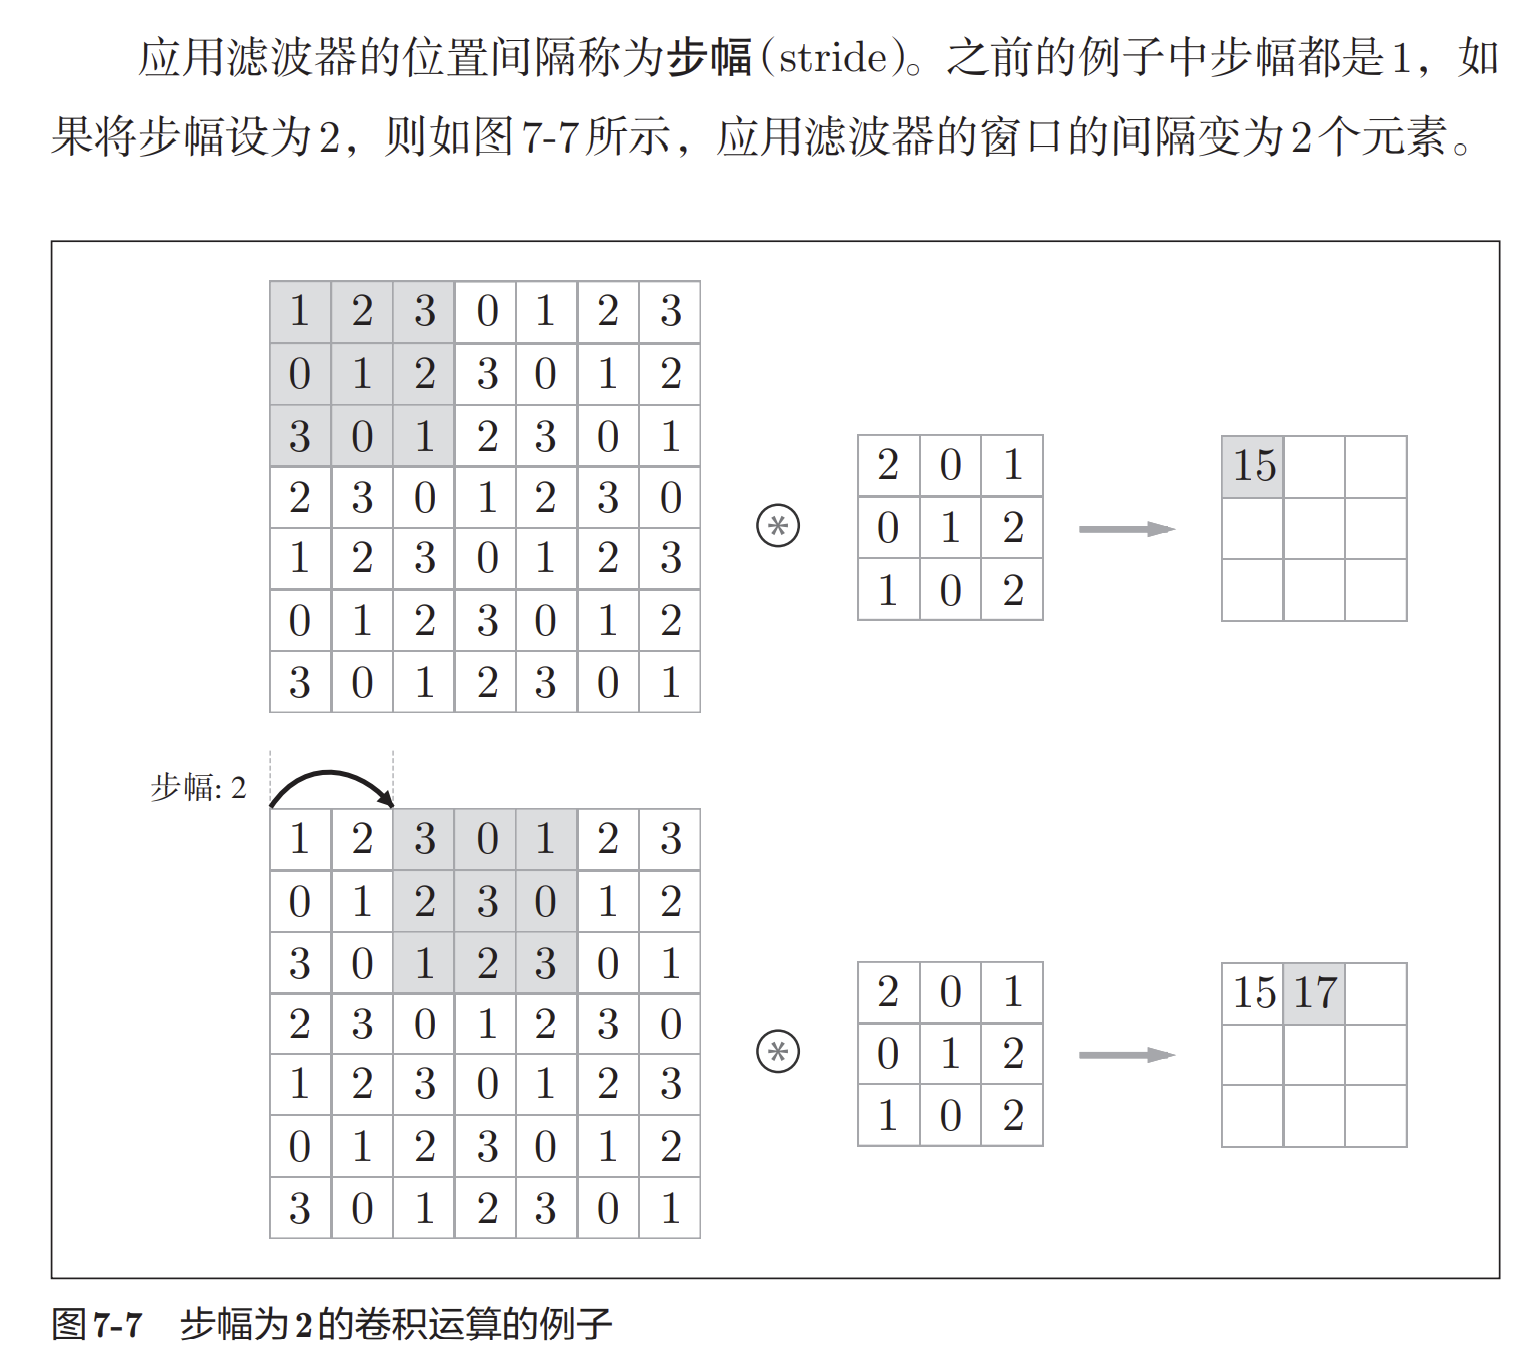


## 计算输出大小

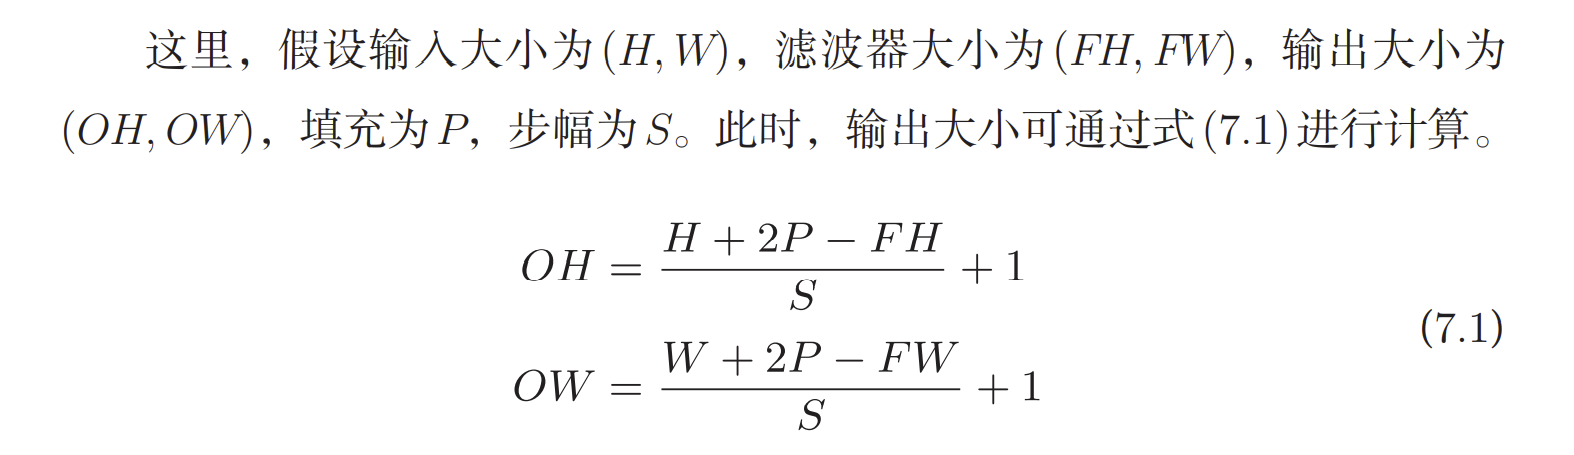

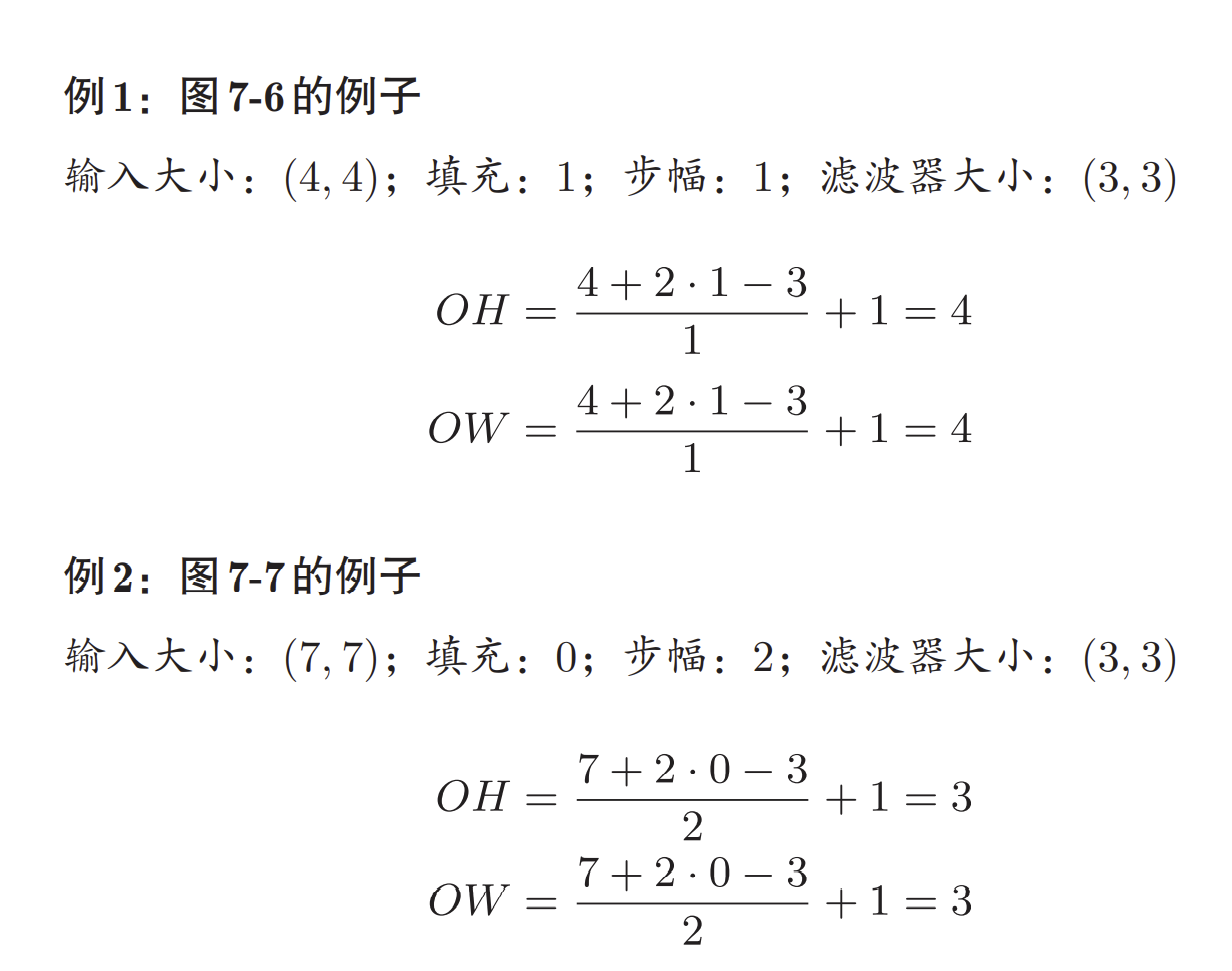

- 需要注意的是：所设定的值必须是计算公式中可以除尽，当输出大小无法除尽时候，需要采取报错等对策。顺便说一下，根据深度学习的框架的不同，当值无法除尽时，有时会向最接近的整数四舍五入，不进行报错而继续运行


## 3维数据的卷积运算
- 通道方向上有多个特征图时，会按通道进行输入数据和滤波器的卷积运算，并将结果相加，从而得到输出。
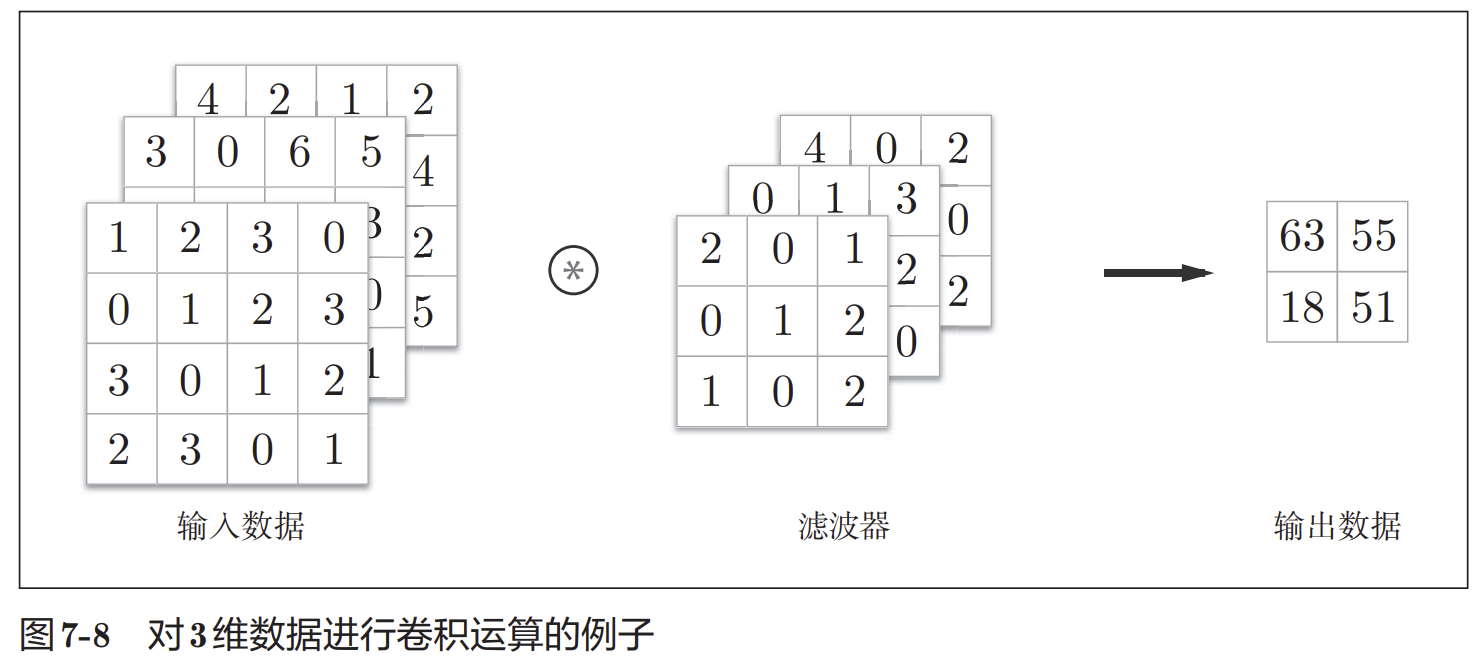

- 在3维数据的卷积运算中，输入数据和滤波器的通道数要设为相同的值。

## 结合方块思考
- 把3维数据表示为多维数组时，书写顺序为（channel, height, width）。比如，通道数为C、高度为H、长度为W的数据的形状可以写成（C, H, W）。滤波器也一样，要按（channel, height, width）的顺序书写。比如，通道数为C、滤波器高度为FH（Filter Height）、长度为FW（Filter Width）时，可以写成（C, FH, FW）

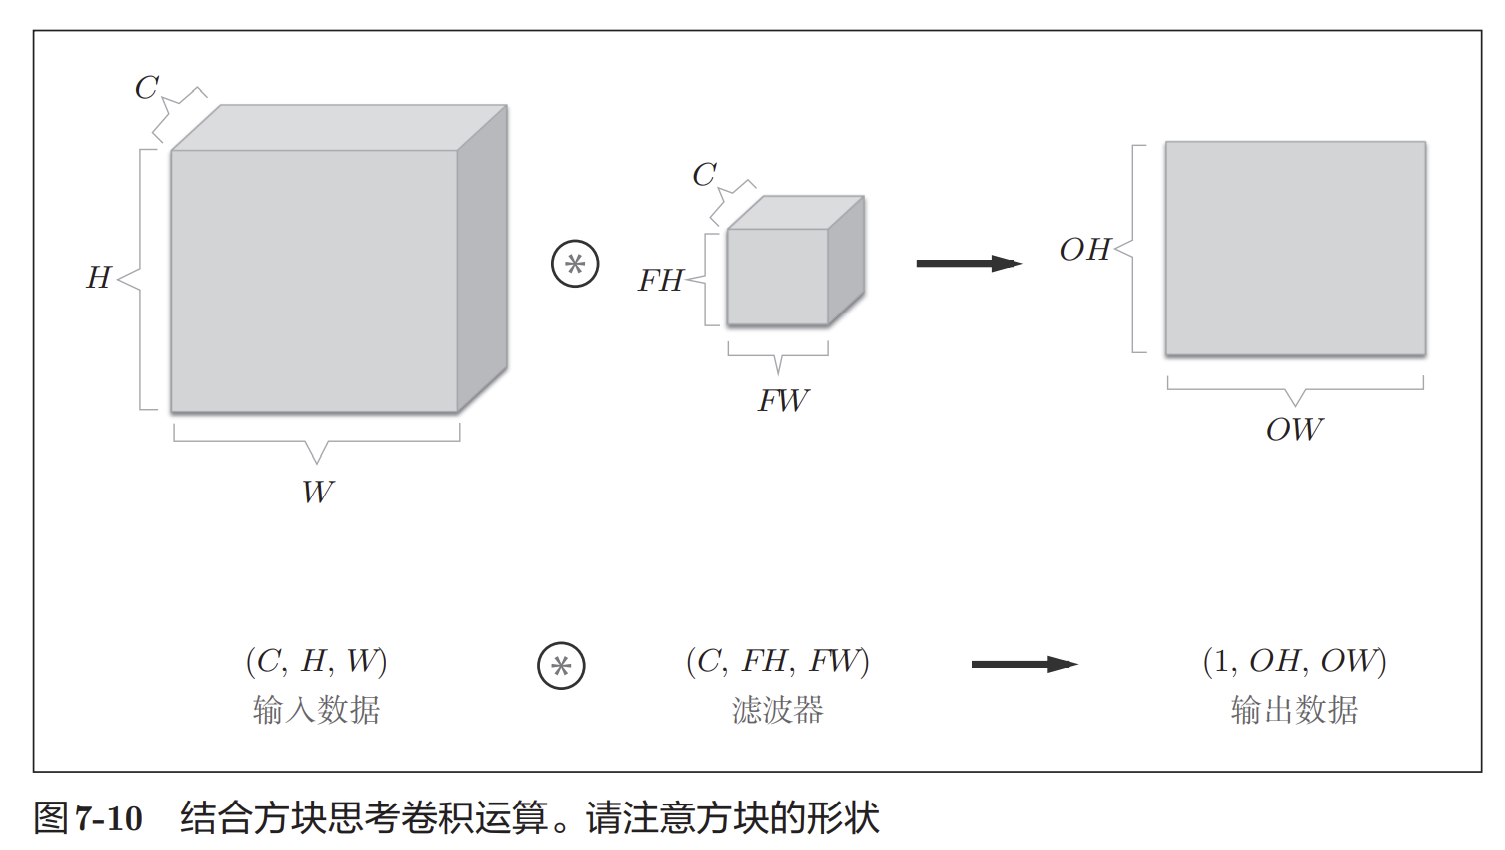

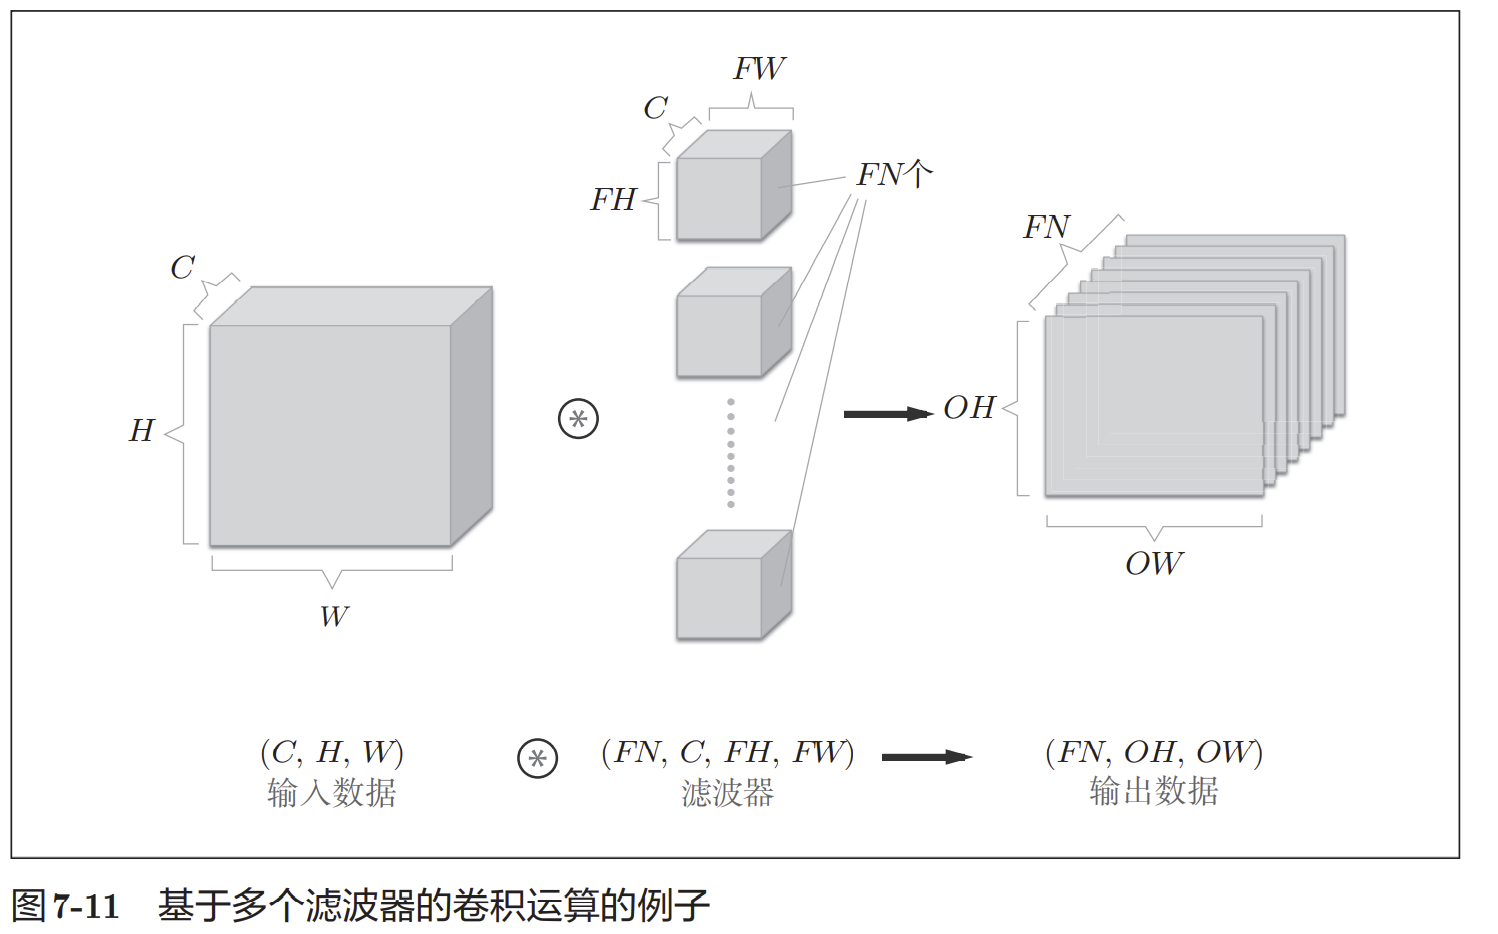

- 通过应用FN个滤波器，输出特征图也生成了FN个。如果将这FN个特征图汇集在一起，就得到了形状为(FN, OH, OW)的方块。将这个方块传给下一层，就是CNN的处理流。
- 关于卷积运算的滤波器，也必须考虑滤波器的数量。因此，作为4维数据，滤波器的权重数据要按(output_channel, input_channel, height, width)的顺序书写。比如，通道数为3、大小为5 × 5的滤波器有20个时，可以写成(20, 3, 5, 5)。

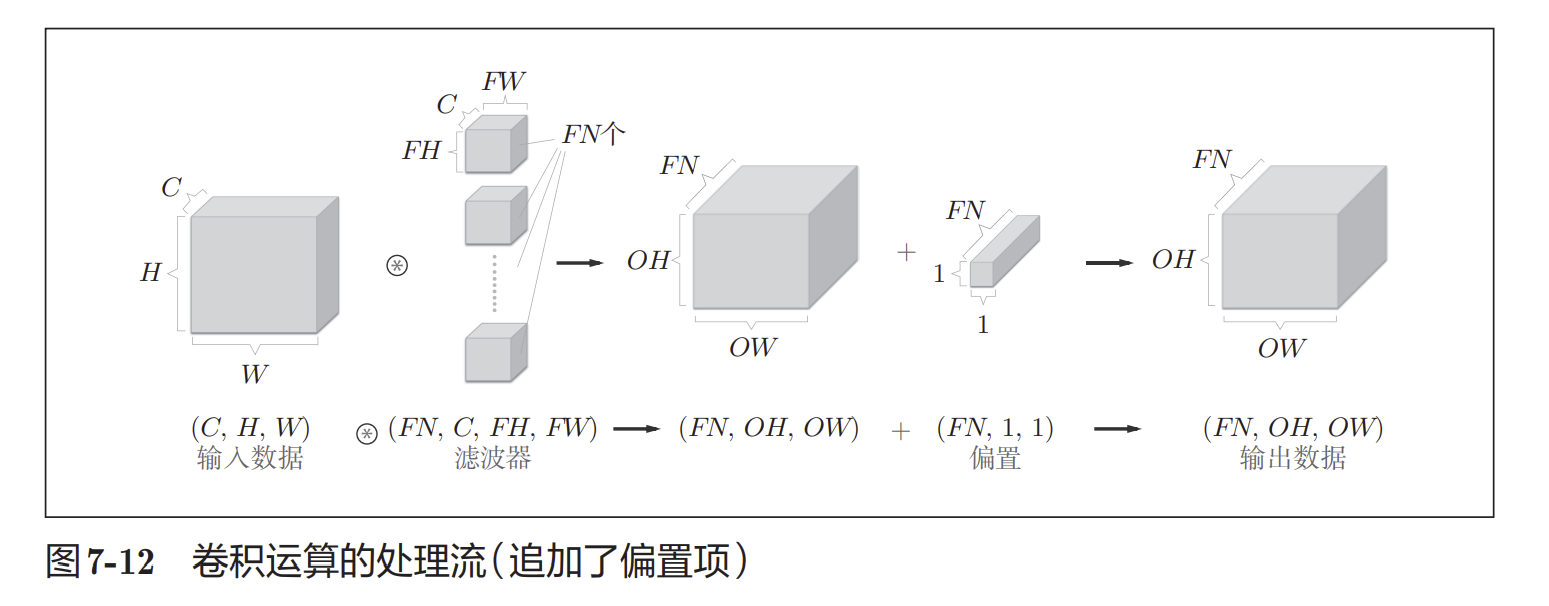


## 批处理
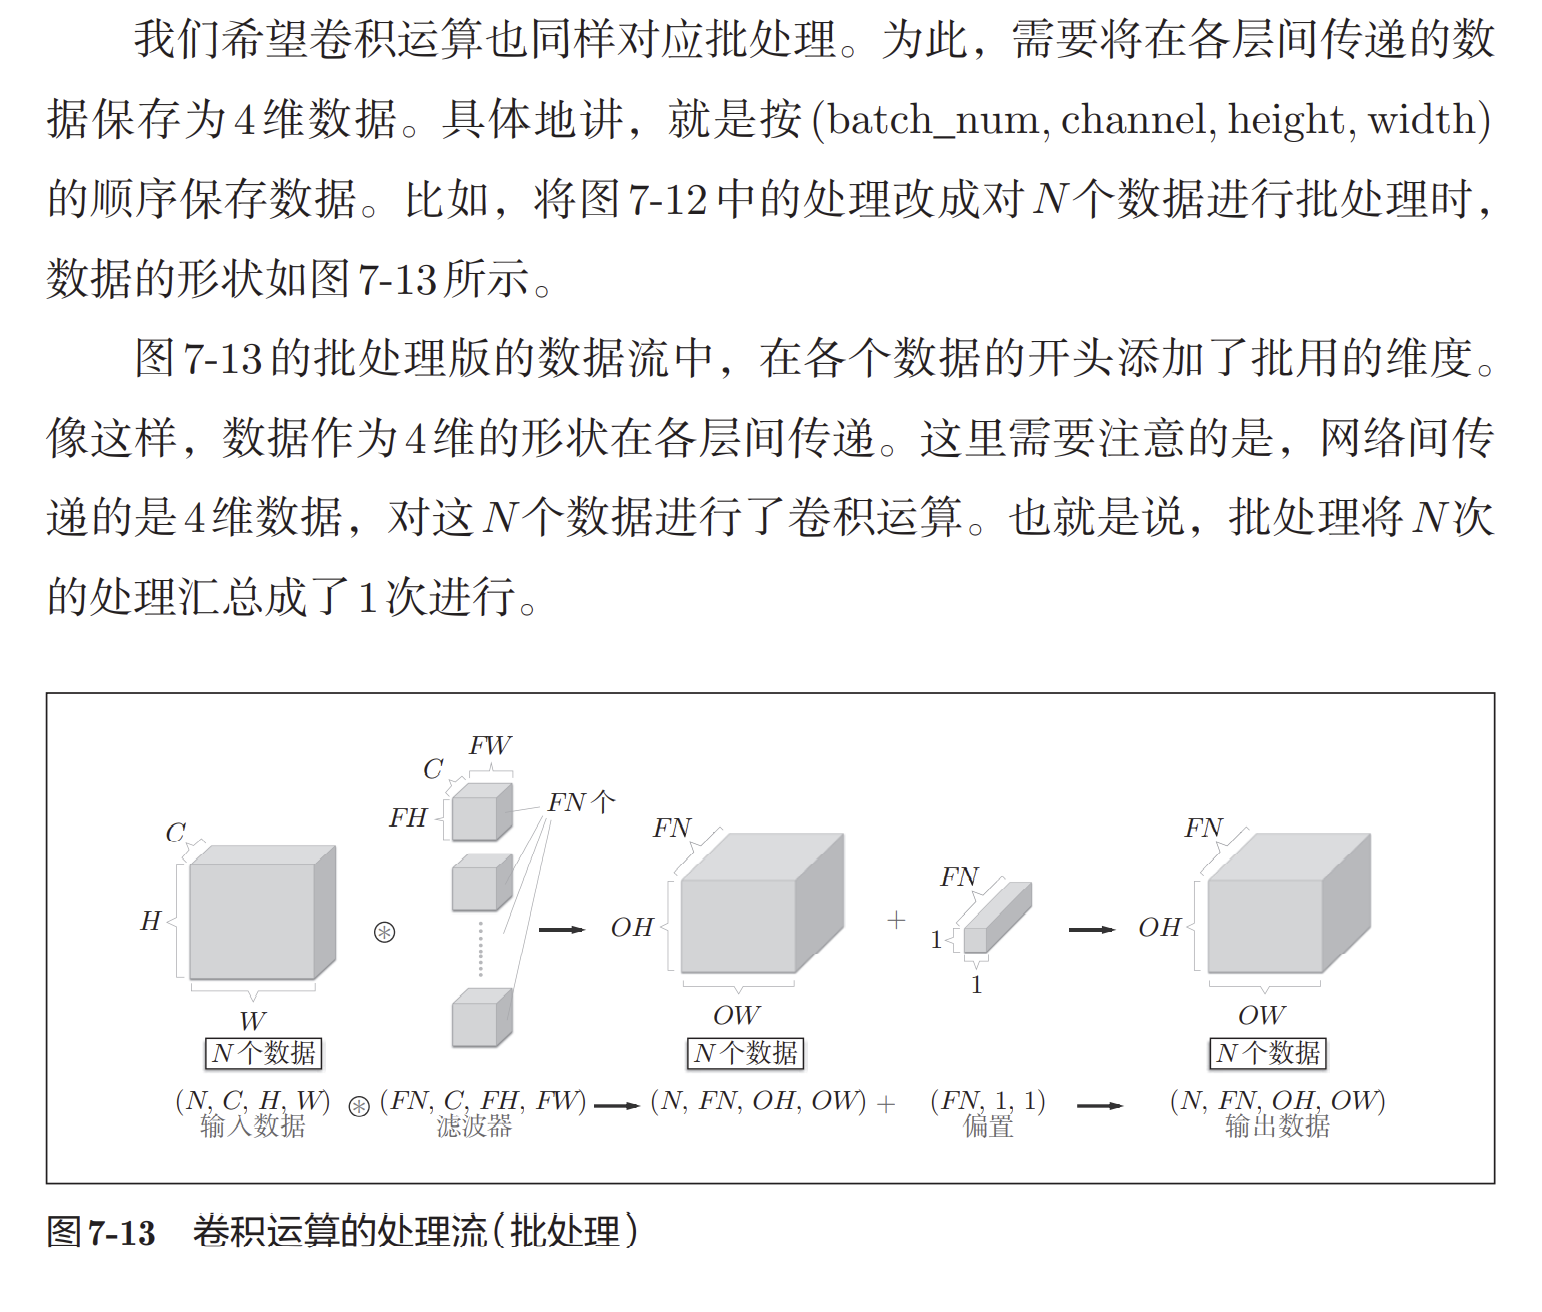

# 池化
- 池化是缩小高、长方向上的空间的运算。
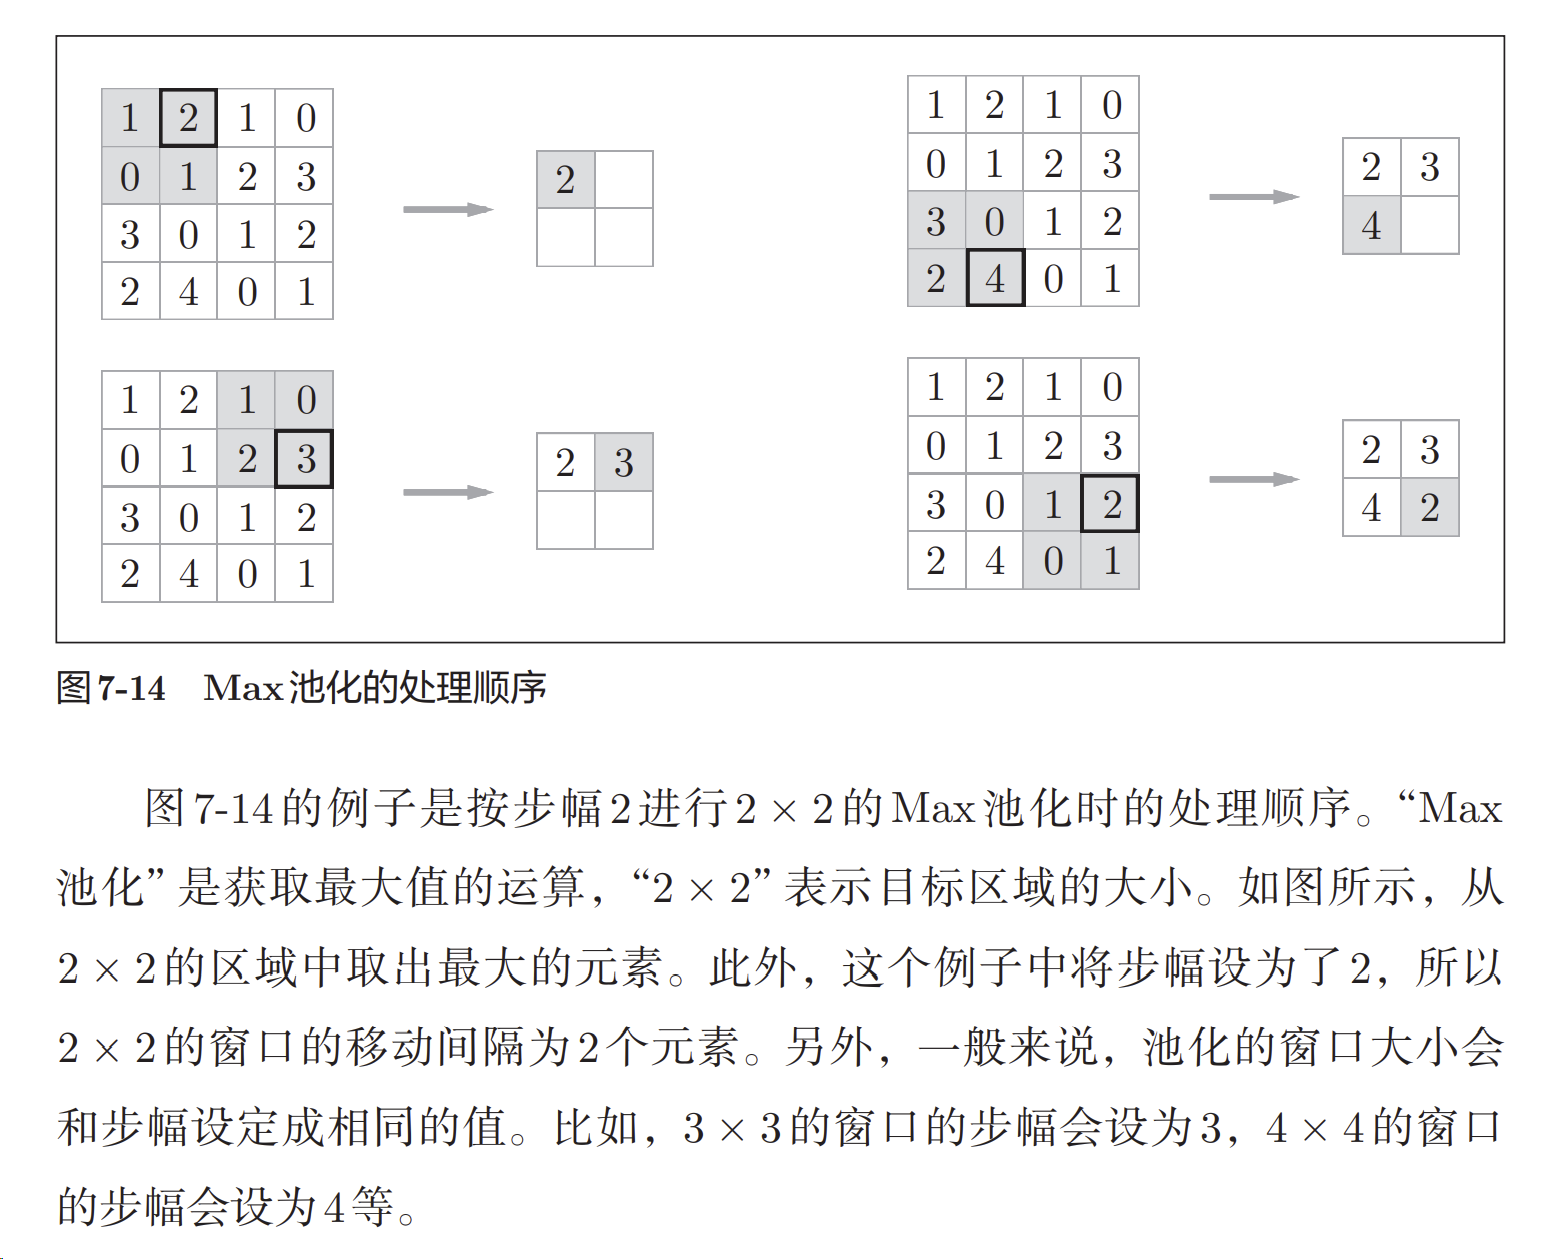

- 除了Max池化之外，还有Average池化等。相对于Max池化是从目标区域中取出最大值，Average池化则是计算目标区域的平均值。在图像识别领域，主要使用Max池化。因此，本书中说到“池化层”时，指的是Max池化。

- 对微小的位置变化具有鲁棒性（健壮）
    - 输入数据发生微小偏差时，池化仍会返回相同的结果。因此，池化对输入数据的微小偏差具有鲁棒性。


In [3]:
import numpy as np

x = np.random.rand(10, 1, 28, 28)

x.shape

(10, 1, 28, 28)

# im2col
- numpy 存在使用for语句后处理变慢的缺点（Numpy中，访问元素最好不要用for语句）
- im2col是image to column的缩写，从图像到矩阵的意思
- 优点：计算更快；缺点：占用内存变大
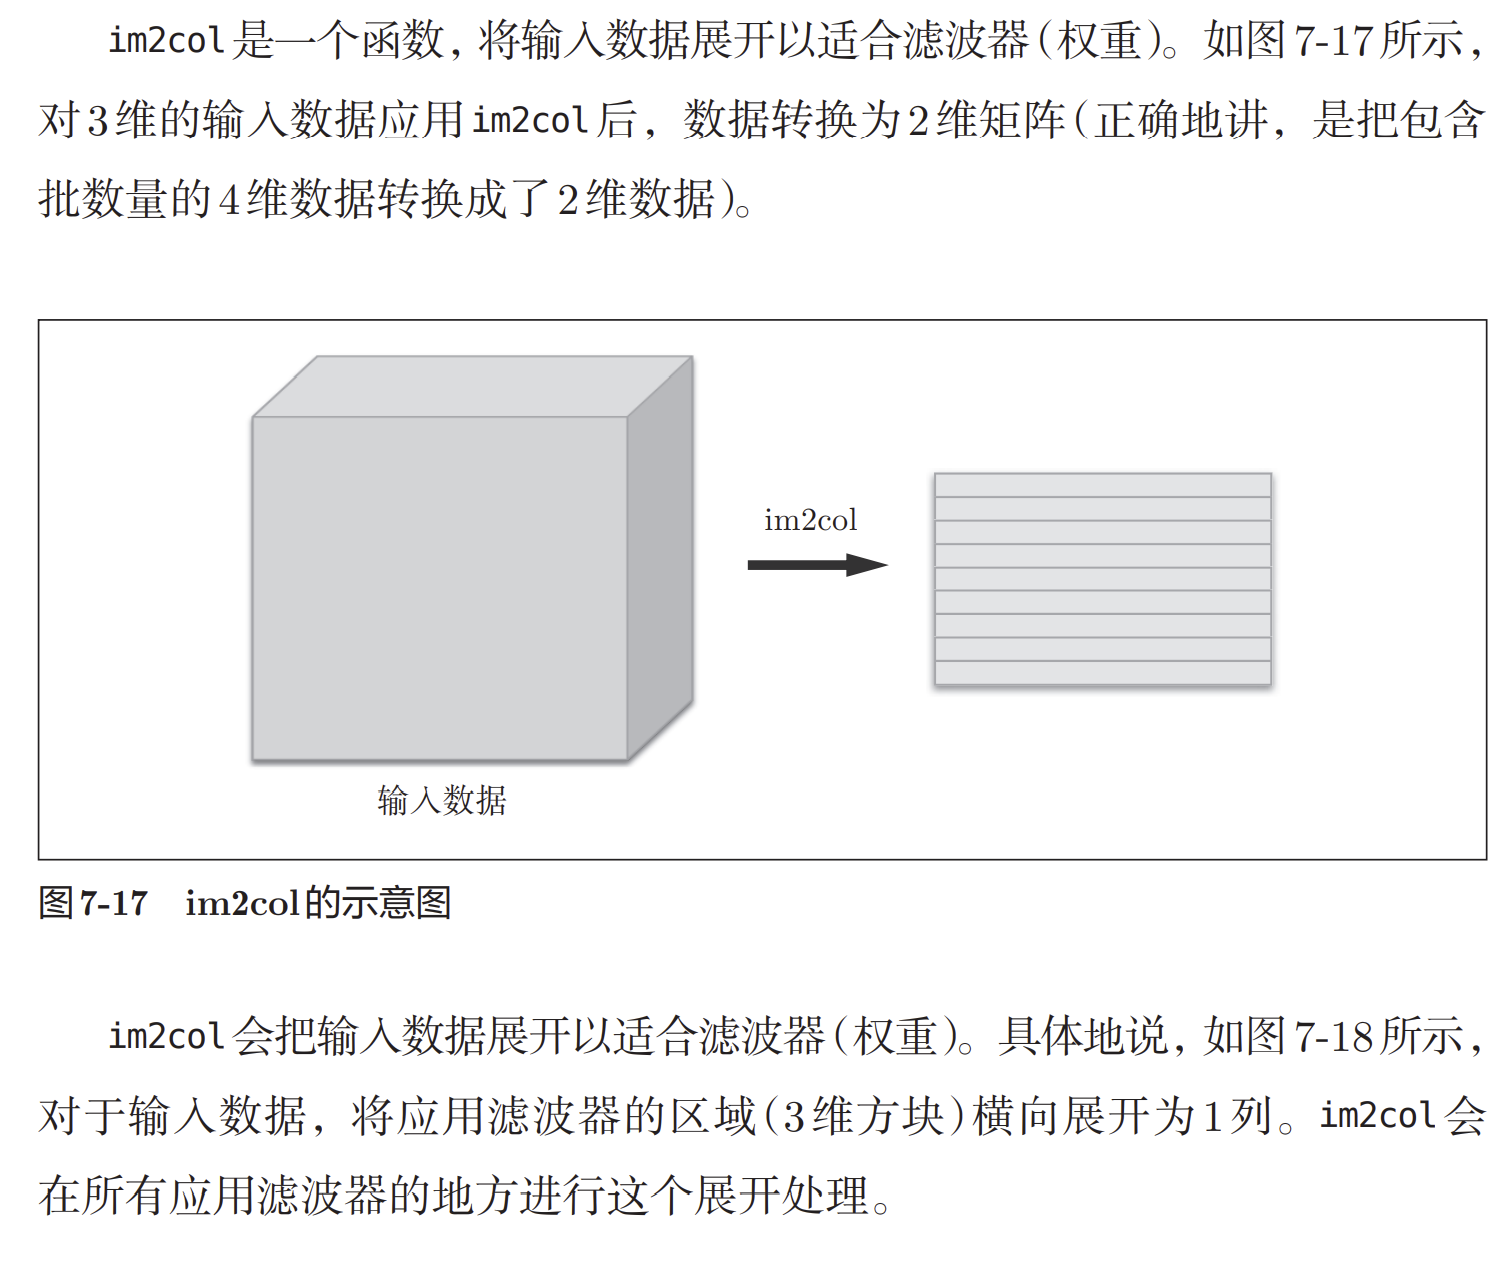
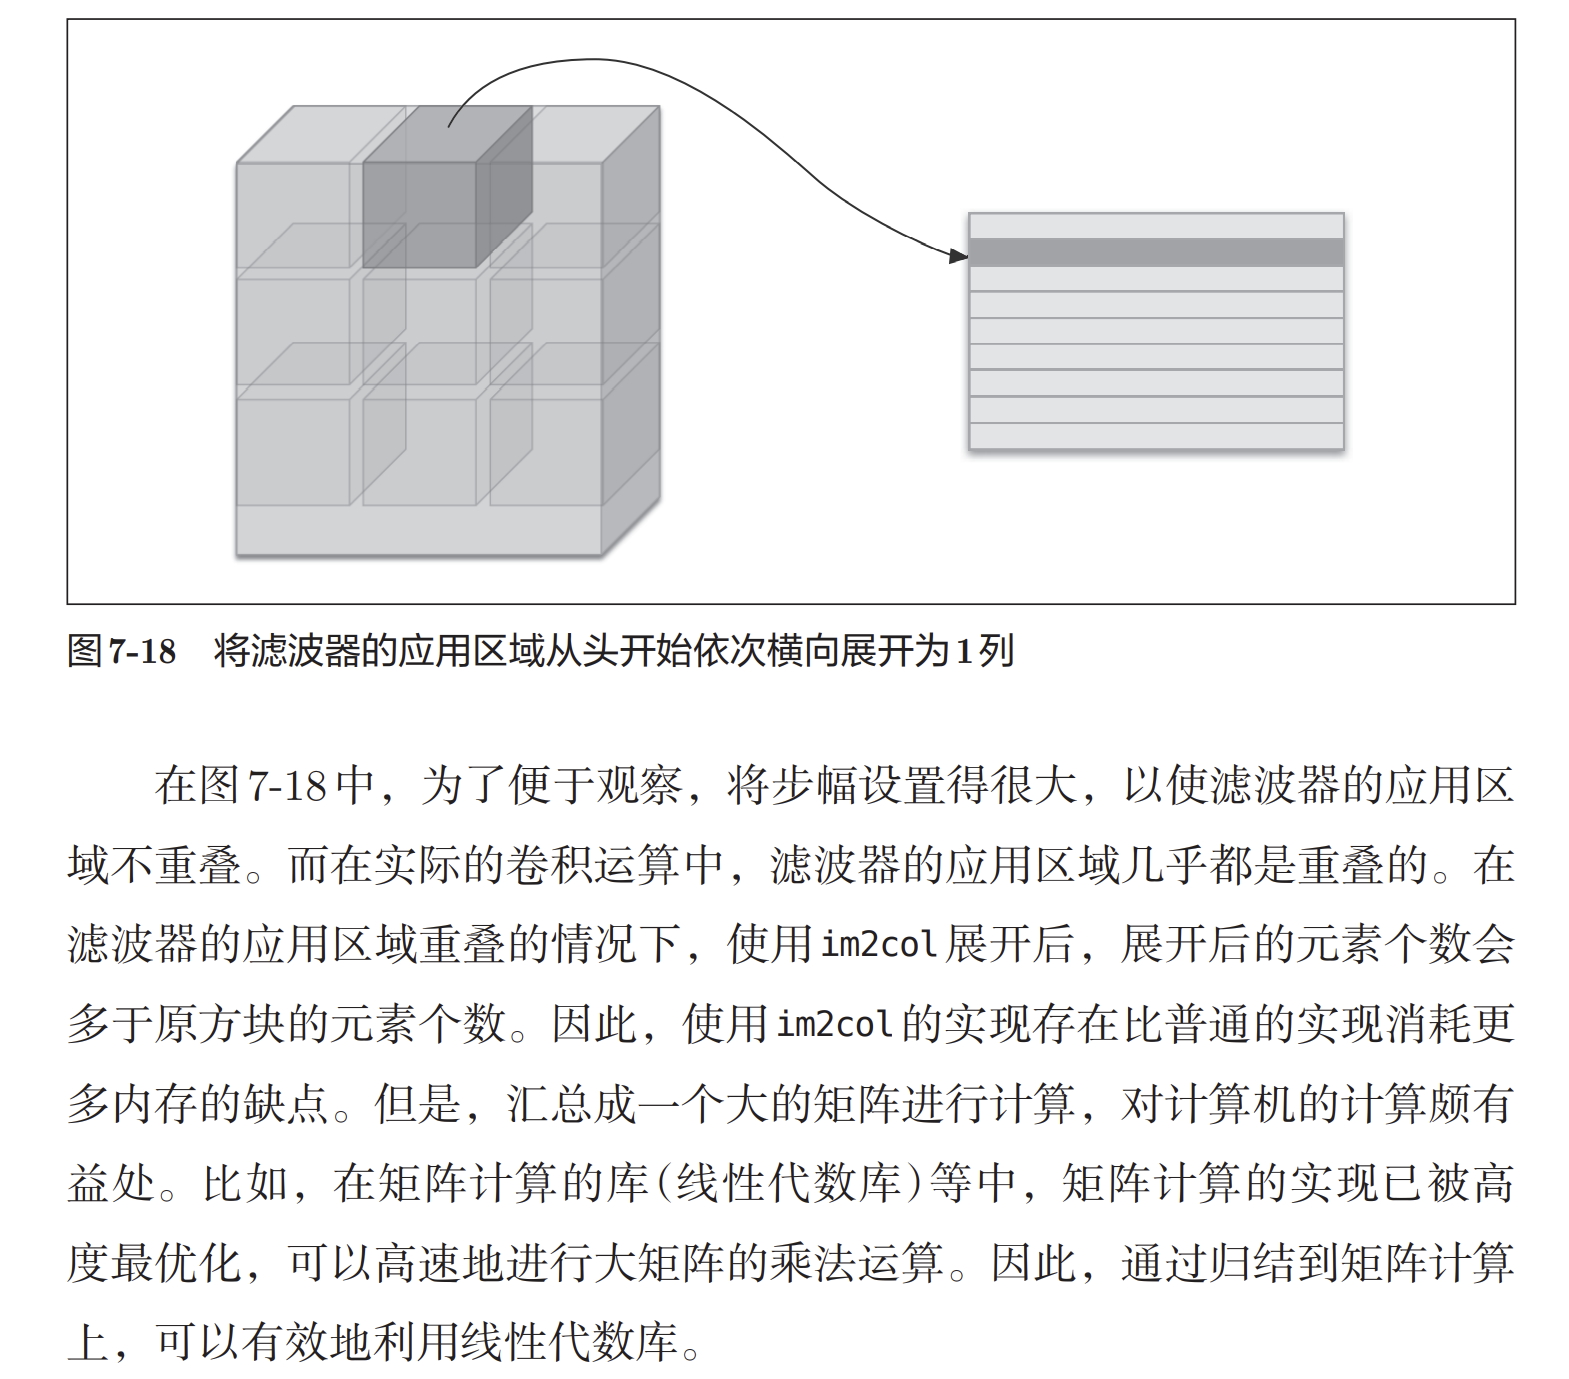
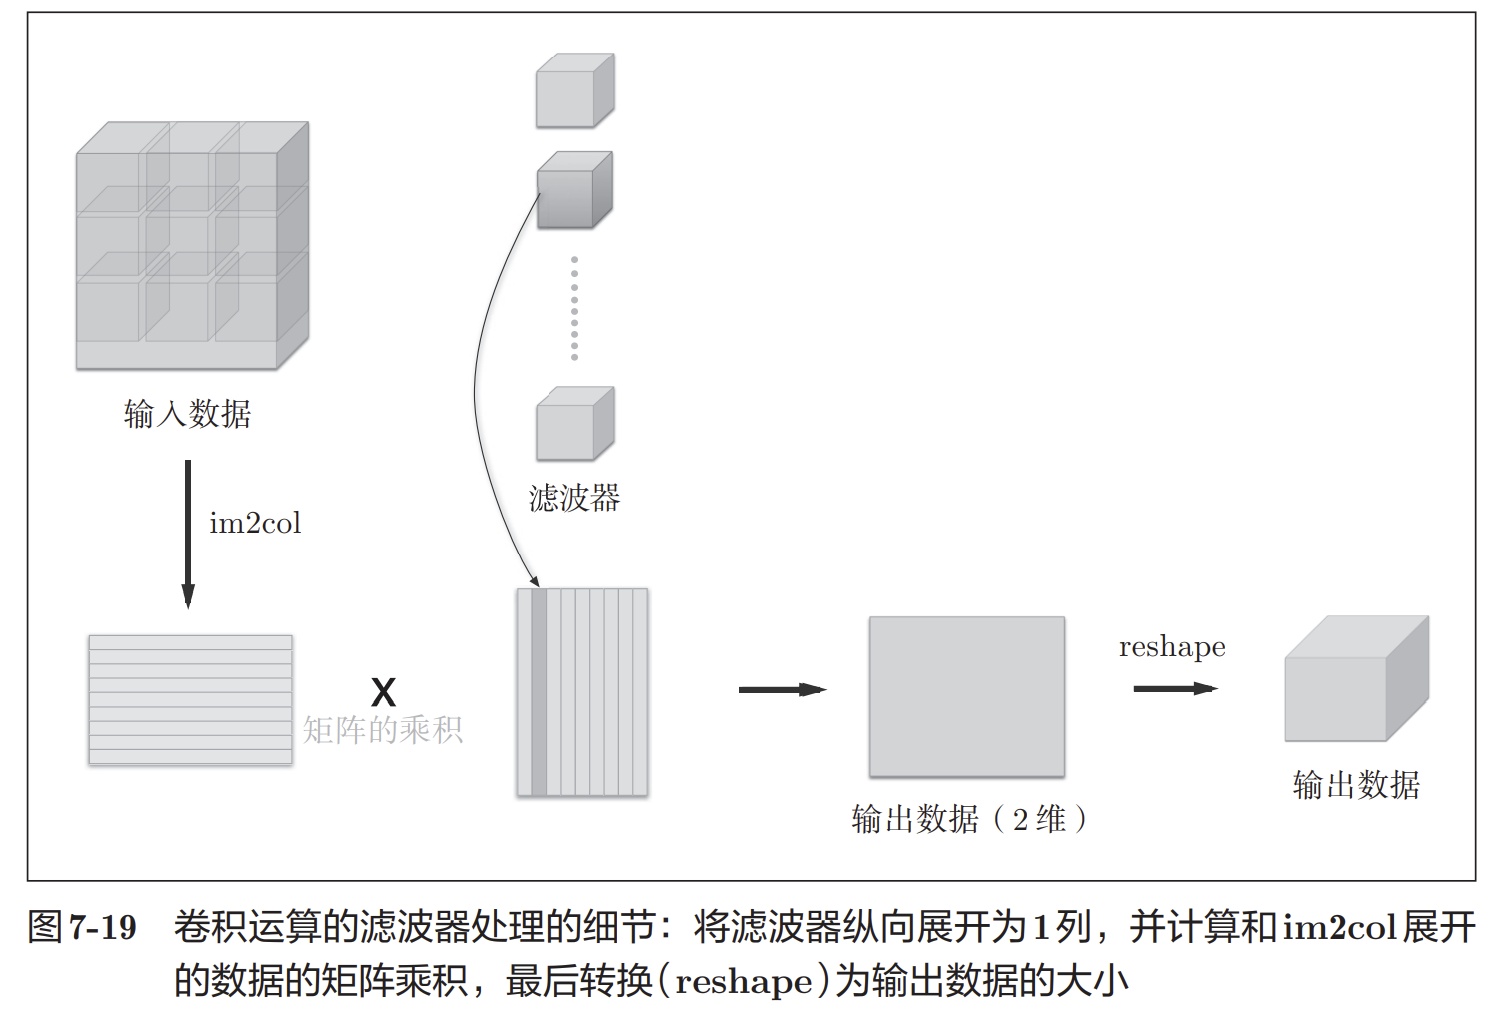

In [8]:
def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    """

    Parameters
    ----------
    input_data:由(数据数，通道，高度，宽度)的四维阵列构成的输入数据  
    filter_h:过滤器的高度  
    filter_w:过滤器的宽度  
    stride: 步长
    pad:填充  

    Returns
    -------
    col : 2次元配列
    """
    N, C, H, W = input_data.shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1

    img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))

    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]

    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)
    return col

# 关于im2col的详细解释

- 专门写了一篇博客来说明相关原理和实现，链接地址见[这里](https://blog.csdn.net/sty945/article/details/125135444)。

In [11]:
x1 = np.random.rand(1, 3, 7, 7)

col1 =  im2col(x1, 5, 5, stride=1, pad=0)

In [13]:
col1.shape

(9, 75)

In [14]:
x2 = np.random.rand(10, 3, 7, 7)
col2 = im2col(x2, 5, 5, stride=1, pad=0)
col2.shape

(90, 75)

- 第一个是批大小为1、通道为3的7 × 7的数据，第二个的批大小为10，数据形状和第一个相同。分别对其应用im2col函数，在这两种情形下，第2维的元素个数均为75。**这是滤波器（通道为3、大小为5 × 5）的元素个数的总和**。批大小为1时，im2col的结果是(9, 75)。而第2个例子中批大小为10，所以保存了10倍的数据，即(90, 75)。

In [17]:
class Convolution:
    def __init__(self, W, b, stride=1, pad=0):
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad
    
    def forward(self, x):
        FN, C, FH, FW = self.W.shape
        N, C, H, W = x.shape
        out_h = int(1 + (H + 2*self.pad - FH) / self.stride)
        out_w = int(1 + (W + 2*self.pad -FW) / self.stride)
        
        col = im2col(x, FH, FW, self.stride, self.pad)
        col_W = self.W.reshape(FN, -1).T
        out = np.dot(col, col_W) + self.b
        
        out = out.reshape(N, out_h, out_W, -1).transpose(0, 3, 1, 2)
        return out

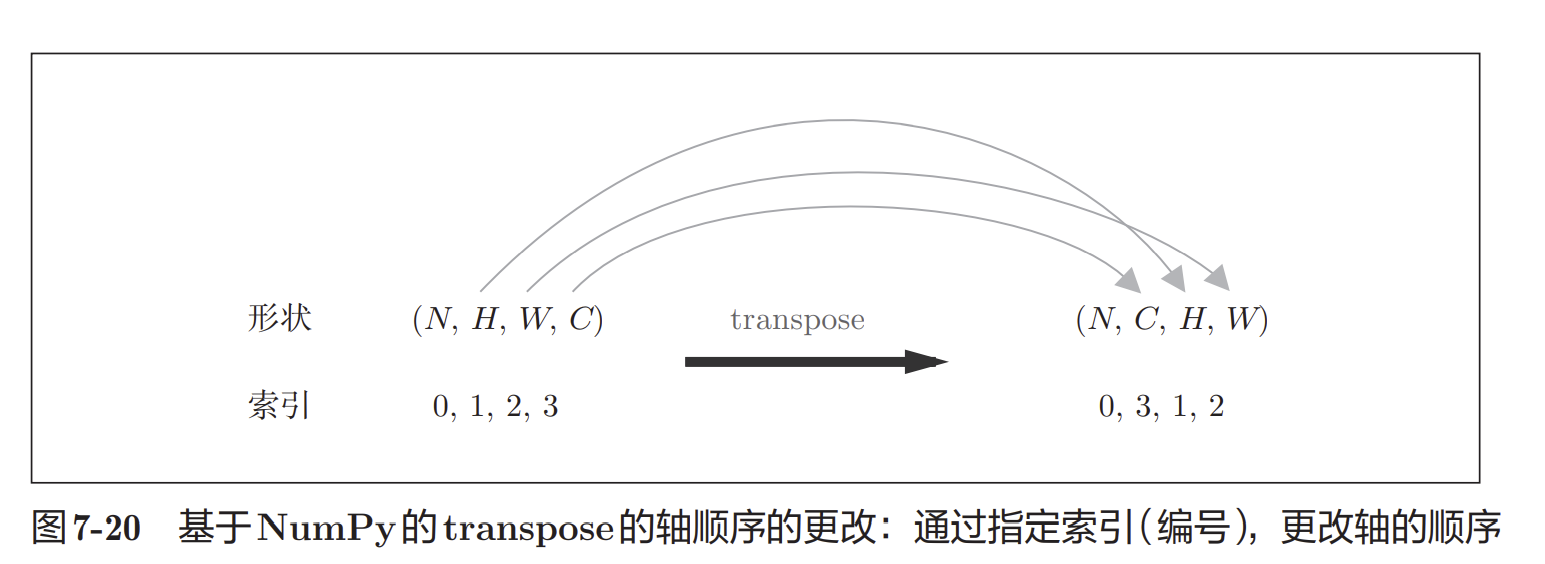

# 池化层的实现

- 池化层的实现和卷积层相同，都使用im2col展开输入数据。不过，池化的情况下，在通道方向上是独立的，这一点和卷积层不同。
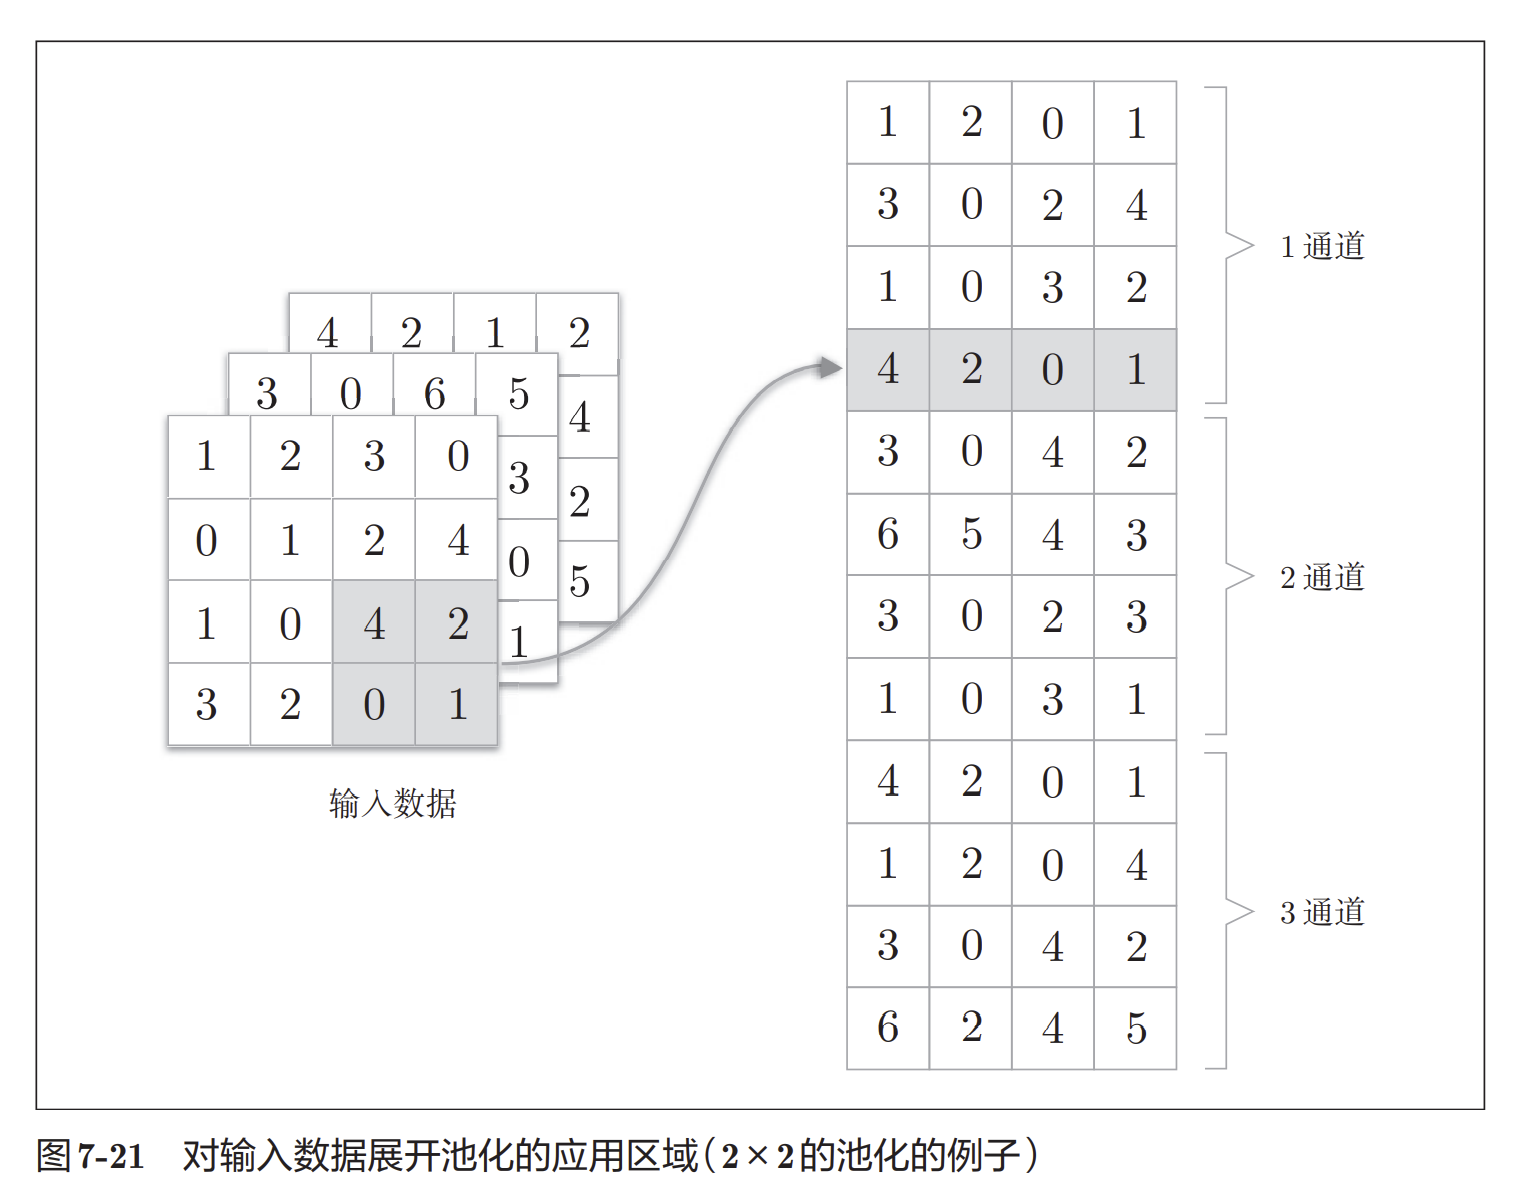
- 像这样展开之后，只需对展开的矩阵求各行的最大值，并转换为合适的形状即可
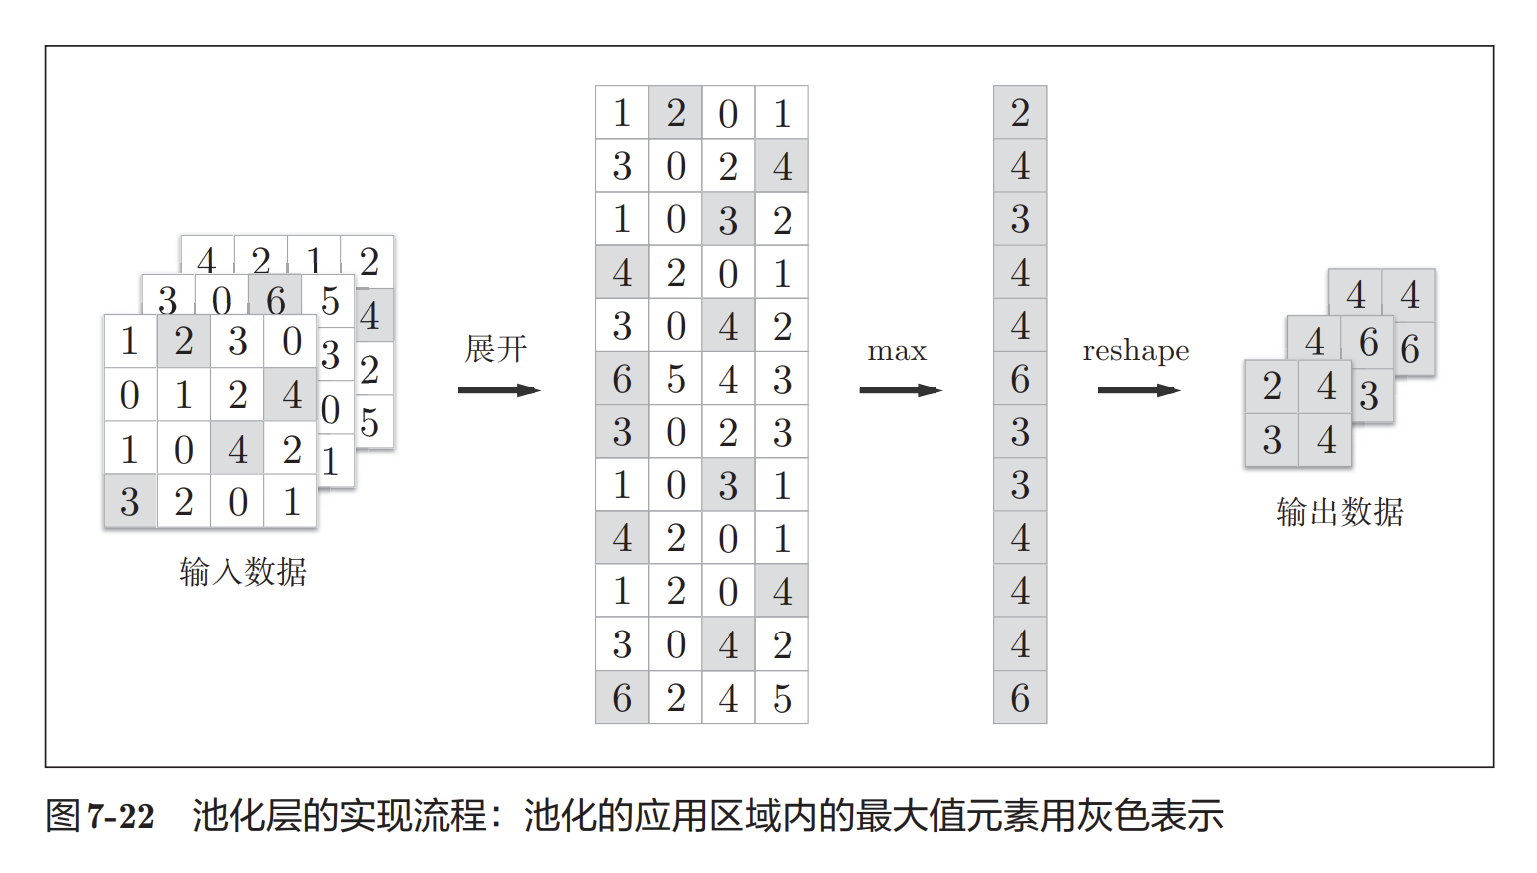

In [24]:
class Pooling:
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad
    
    def forward(self, x):
        N, C, H, W = x.shape
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)
        # 展开输入数据
        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(-1, self.pool_h * self.pool_w)
        # 求各行的最大值
        out = np.max(col, axis=1)
        # 转换为合适的输出大小
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)
        return out

# CNN的实现
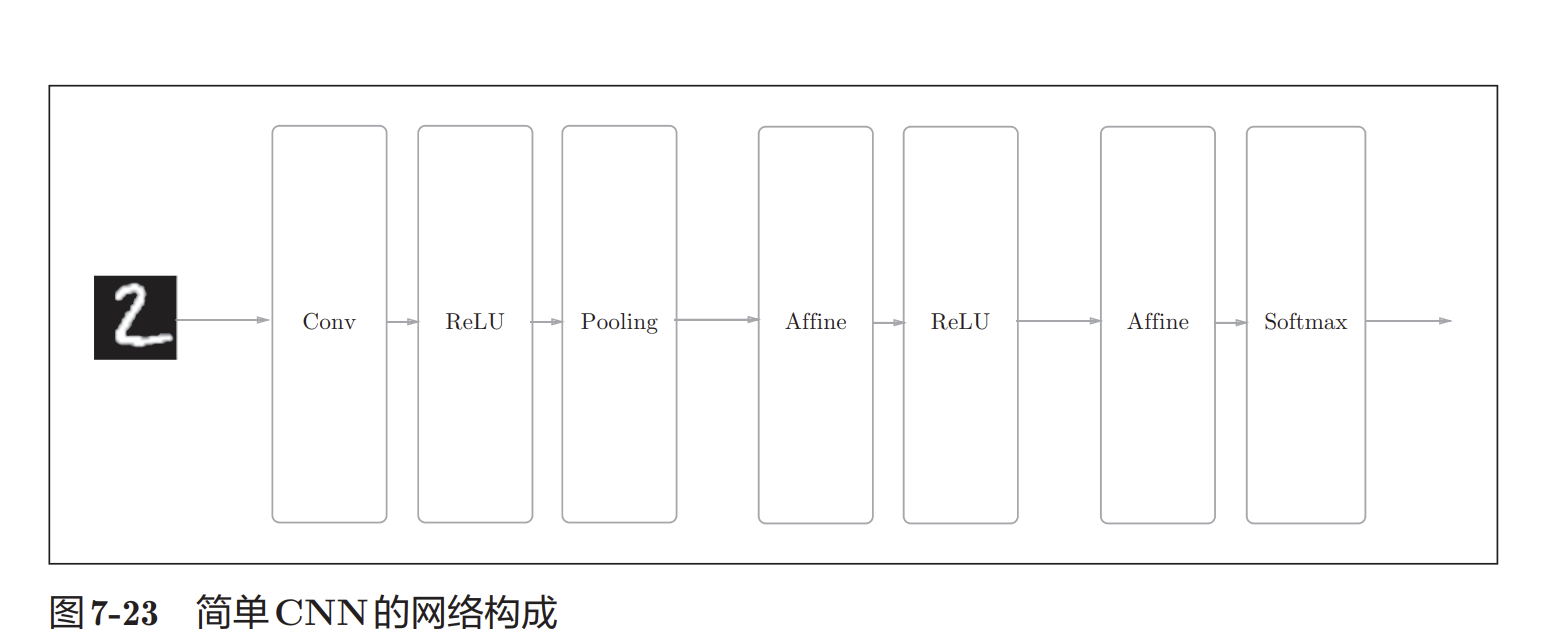

- 网络的构成是“Convolution - ReLU - Pooling - Affine - ReLU - Affine - Softmax”

In [ ]:
from collections import OrderedDict
class SimpleConvNet:
    def __init__(self, input_dim=(1, 28, 28), conv_param-={'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
                hidden_size=100, output_size=10, weight_init_std=0.01):
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1]
        
        conv_output_size = (input_size - filter_size + 2 * filter_pad) / filter_stride + 1
        pool_output_size = int(filter_num * (conv_output_size/2)) * (conv_output_size/2))
        
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std * np.random.randn(pool_output_size, hidden_size)
        
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std * np.random.randn(hidden_size, output_size)
        
        self.params['b3'] = np.zeros(output_size) 
        
        self.layers = OrderDict()
        self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'], conv_param['stride'], conv_param['pad'])
        
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
        
        self.layers['Relu2'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])
        self.last_layer = softmaxwithloss()
    
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        return x
    
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)
    
    def gradient(self, x, t):
        # forward
        self.loss(x, t)
        
        # backward
        dout = 1
        dout = self.lastLayer.backward(dout)
        
        layers = list(self.layers.values)
        layers.reverse()
        
        for layer in layers:
            dout = layer.backward(dout)
        
        grads = {}
        grads['W1'] = self.layers['Conv1'].dW
        grads['b1'] = self.layers['Conv1'].db
        grads['W2'] = self.layers['Affine1'].dW
        grads['b2'] = self.layers['Affine1'].db
        grads['W3'] = self.layers['Affine2'].dW
        grads['b3'] = self.layers['Affine2'].db
        return grads
        

# AlexNet vs LeNet
- 激活函数使用ReLU
- 使用进行局部正规化的LRN(Local Response Normalization)
- 使用Dropout